# Dataset tutorial

This notebook walks you through loading the datasets from The Well, processing the data and using a dataset to train a simple neural network.

In [ ]:
# !pip install the_well[benchmark]

import matplotlib.pyplot as plt
import numpy as np
import torch
from einops import rearrange
from neuralop.models import FNO
from tqdm import tqdm

from the_well.benchmark.metrics import VRMSE
from the_well.data import WellDataset
from the_well.utils.download import well_download

device = "cuda"
base_path = "./datasets"  # path/to/storage

## Download data

First let's download the data relevant for this tutorial. In this notebook, we use `turbulent_radiative_layer_2D` as it is the smallest dataset in The Well.

In [2]:
well_download(base_path=base_path, dataset="turbulent_radiative_layer_2D", split="train")

** Resuming transfer from byte position 635467072
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   197  100   197    0     0  10944      0 --:--:-- --:--:-- --:--:-- 10944
100   197  100   197    0     0  49250      0 --:--:-- --:--:-- --:--:-- 49250
100   197  100   197    0     0  65666      0 --:--:-- --:--:-- --:--:-- 65666
100   197  100   197    0     0  65666      0 --:--:-- --:--:-- --:--:-- 65666
100   197  100   197    0     0  65666      0 --:--:-- --:--:-- --:--:-- 65666
100   197  100   197    0     0  65666      0 --:--:-- --:--:-- --:--:-- 65666
100   197  100   197    0     0  65666      0 --:--:-- --:--:-- --:--:-- 65666
100   197  100   197    0     0  65666      0 --:--:-- --:--:-- --:--:-- 65666
100   197  100   197    0     0  65666      0 --:--:-- --:--:-- --:--:-- 65666


In [3]:
well_download(base_path=base_path, dataset="turbulent_radiative_layer_2D", split="valid")

** Resuming transfer from byte position 79459648
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   197  100   197    0     0  16416      0 --:--:-- --:--:-- --:--:-- 16416
100   197  100   197    0     0   192k      0 --:--:-- --:--:-- --:--:--  192k
100   197  100   197    0     0   192k      0 --:--:-- --:--:-- --:--:--  192k
100   197  100   197    0     0   192k      0 --:--:-- --:--:-- --:--:--  192k
100   197  100   197    0     0   192k      0 --:--:-- --:--:-- --:--:--  192k
100   197  100   197    0     0   192k      0 --:--:-- --:--:-- --:--:--  192k
100   197  100   197    0     0   192k      0 --:--:-- --:--:-- --:--:--  192k
100   197  100   197    0     0   192k      0 --:--:-- --:--:-- --:--:--  192k
100   197  100   197    0     0   192k      0 --:--:-- --:--:-- --:--:--  192k


## Dataset object

To load a dataset from The Well, the easiest way is to use the `WellDataset` class.

In [4]:
dataset = WellDataset(
    well_base_path=base_path,
    well_dataset_name="turbulent_radiative_layer_2D",
    well_split_name="train",
    n_steps_input=4,
    n_steps_output=1,
    use_normalization=False,
)

The dataset object is an instance of a PyTorch dataset (`torch.utils.data.Dataset`). Each item in the dataset is a dictionnary that contains 6 elements.

In [5]:
item = dataset[0]

list(item.keys())

['input_fields',
 'output_fields',
 'constant_scalars',
 'boundary_conditions',
 'space_grid',
 'input_time_grid',
 'output_time_grid']

The most important elements are `input_fields` and `output_fields`. They represent the time-varying physical fields of the dynamical system and are generally the input and target of our models. For a dynamical system that has 2 spatial dimensions $x$ and $y$, `input_fields` would have a shape $(T_{in}, L_x, L_y, F)$ and `output_fields` would have a shape $(T_{out}, L_x, L_y, F)$. The number of input and output timesteps $T_{in}$ and $T_{out}$ are specified at the instantiation of the dataset with the arguments `n_steps_input` and `n_steps_output`. $L_x$ and $L_y$ are the lengths of the spatial dimensions. $F$ represents the number of physical fields, where vector fields $v = (v_x, v_y)$ and tensor fields $t = (t_{xx}, t_{xy}, t_{yx}, t_{yy})$ are flattened.

In [6]:
item["input_fields"].shape

torch.Size([4, 128, 384, 4])

In [7]:
item["output_fields"].shape

torch.Size([1, 128, 384, 4])

One can access the names of the fields in `dataset.metadata.field_names`. The names are organized by the fields' tensor-order. In this dataset, the momentum is a vector field (first-order tensor).

In [8]:
dataset.metadata.field_names

{0: ['density', 'pressure'], 1: ['velocity_x', 'velocity_y'], 2: []}

In [9]:
field_names = [
    name for group in dataset.metadata.field_names.values() for name in group
]
field_names

['density', 'pressure', 'velocity_x', 'velocity_y']

In an item, the input and output form a time-contiguous window in the trajectories. The total number of available windows in the dataset depends on the number of files, trajectories per file and timesteps per trajectory.

In [10]:
window_size = dataset.n_steps_input + dataset.n_steps_output

total_windows = 0
for i in range(dataset.metadata.n_files):
    windows_per_trajectory = (
        dataset.metadata.n_steps_per_trajectory[i] - window_size + 1
    )
    total_windows += (
        windows_per_trajectory * dataset.metadata.n_trajectories_per_file[i]
    )

print(total_windows)

6984


Conveniently, this corresponds to the length of the dataset.

In [11]:
len(dataset)

6984

## Visualize the data

The easiest way to visualize the data is to plot the fields separately. 

In [12]:
F = dataset.metadata.n_fields

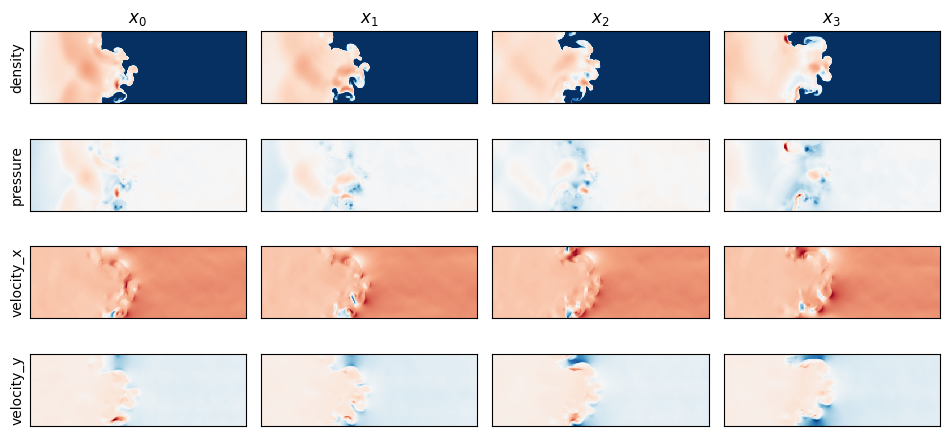

In [13]:
x = dataset[42]["input_fields"]
x = rearrange(x, "T Lx Ly F -> F T Lx Ly")

fig, axs = plt.subplots(F, 4, figsize=(4 * 2.4, F * 1.2))

for field in range(F):
    vmin = np.nanmin(x[field])
    vmax = np.nanmax(x[field])

    axs[field, 0].set_ylabel(f"{field_names[field]}")

    for t in range(4):
        axs[field, t].imshow(
            x[field, t], cmap="RdBu_r", interpolation="none", vmin=vmin, vmax=vmax
        )
        axs[field, t].set_xticks([])
        axs[field, t].set_yticks([])

        axs[0, t].set_title(f"$x_{t}$")

plt.tight_layout()

## Processing

In most datasets of The Well, some quantities are always positive and/or vary greatly in magnitude. These quantities should be preprocessed before being passed to a neural network. In this notebook, we standardize the fields with respect to their mean and standard deviation over a subset of the training set. Alternatively one could set `use_normalization=True` when instantiating the dataset, which would standardize the fields with respect to their mean and standard deviation over the entire training set.

In [14]:
xs = []

for i in range(0, 1000, 100):
    x = dataset[i]["input_fields"]
    xs.append(x)

xs = torch.stack(xs)

In [15]:
mu = xs.reshape(-1, F).mean(dim=0).to(device)
sigma = xs.reshape(-1, F).std(dim=0).to(device)

In [16]:
def preprocess(x):
    return (x - mu) / sigma


def postprocess(x):
    return sigma * x + mu

## Training

We train a small Fourier Neural Operator (FNO) to predict the $T_{out} = 1$ next states given the $T_{in} = 4$ previous states. We concatenate the input steps along their channels, such that the model expects $T_{in} \times F$ channels as input and $T_{out} \times F$ channels as output. Because `WellDataset` is a PyTorch dataset, we can use it conveniently with PyTorch data-loaders.

In [17]:
model = FNO(
    n_modes=(16, 16),
    in_channels=4 * F,
    out_channels=1 * F,
    hidden_channels=128,
    n_layers=5,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

In [18]:
train_loader = torch.utils.data.DataLoader(
    dataset=dataset,
    shuffle=True,
    batch_size=4,
    num_workers=4,
)

for epoch in range(1):
    for batch in (bar := tqdm(train_loader)):
        x = batch["input_fields"]
        x = x.to(device)
        x = preprocess(x)
        x = rearrange(x, "B Ti Lx Ly F -> B (Ti F) Lx Ly")

        y = batch["output_fields"]
        y = y.to(device)
        y = preprocess(y)
        y = rearrange(y, "B To Lx Ly F -> B (To F) Lx Ly")

        fx = model(x)

        mse = (fx - y).square().mean()
        mse.backward()

        optimizer.step()
        optimizer.zero_grad()

        bar.set_postfix(loss=mse.detach().item())

100%|██████████| 1746/1746 [01:18<00:00, 22.23it/s, loss=0.335] 


## Evaluation

Now that our model is trained, we can use it to make predictions. We evaluate the prediction with the variance-scaled root mean squared error (VRMSE) per field. In the manuscript, we report the VRMSE averaged over all fields.

In [19]:
validset = WellDataset(
    well_base_path=base_path,
    well_dataset_name="turbulent_radiative_layer_2D",
    well_split_name="valid",
    n_steps_input=4,
    n_steps_output=1,
    use_normalization=False,
)

In [20]:
item = validset[123]

x = item["input_fields"]
x = x.to(device)
x = preprocess(x)
x = rearrange(x, "Ti Lx Ly F -> 1 (Ti F) Lx Ly")

y = item["output_fields"]
y = y.to(device)

with torch.no_grad():
    fx = model(x)
    fx = rearrange(fx, "1 (To F) Lx Ly -> To Lx Ly F", F=F)
    fx = postprocess(fx)

VRMSE.eval(fx, y, meta=validset.metadata)

tensor([[0.2311, 1.2917, 0.5378, 0.5457]], device='cuda:0')